In [1]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from fisher_resnet import *

Make corresponding plots over all runs of pruning

Specify data type for aggregating and plotting

In [2]:
data = 'cifar100'
if data == 'cifar10':
    n_classes = 10
    base_path = 'resnet_cifar10/'
else:
    n_classes = 100
    base_path = 'resnet_cifar100/'
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Specify test transforms and test data

In [3]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if data == 'cifar10':
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
else:
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
    
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

Files already downloaded and verified


Specify number of runs and make array for accuracy

In [4]:
n = 3
percentiles = np.arange(0, 95, 15)[1:]
errors = np.zeros((percentiles.shape[0] + 1, n))

In [5]:
for i in range(percentiles.shape[0] + 1):
    for j in range(n):
        net = resnet50(n_classes)
        net.load_state_dict(torch.load(base_path + str(i) + '_' + str(j) + '.pth'))
        net.to(device)
        
        net.eval()
        with torch.no_grad():
            correct = 0.
            for input, target in tqdm(testloader):
                input = input.to(device)
                target = target.to(device)

                output = net(input)
                _, predicted = torch.max(output.data, 1)
                correct += (predicted == target).sum().item()
                
            errors[i, j] = correct / len(testset)

100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Obtained accuracy

In [6]:
errors

array([[0.6998, 0.701 , 0.7013],
       [0.7136, 0.7186, 0.7067],
       [0.7071, 0.7158, 0.7103],
       [0.7166, 0.7232, 0.7127],
       [0.7221, 0.7201, 0.7263],
       [0.7103, 0.7177, 0.716 ],
       [0.6772, 0.6856, 0.6765]])

Compute means

In [7]:
means = np.mean(errors, axis=1)
means

array([0.7007    , 0.71296667, 0.71106667, 0.7175    , 0.72283333,
       0.71466667, 0.67976667])

In [8]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


Plot

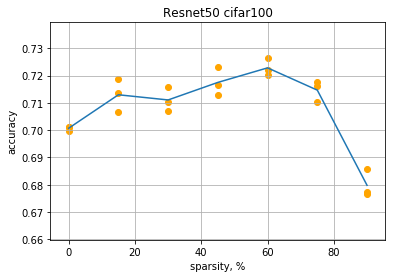

In [9]:
x_axis = [0] + list(percentiles)
for i in range(n):
    scatter(x_axis, errors[:, i], c='orange')
plot(x_axis, means)
grid()
xlabel('sparsity, %')
ylabel('accuracy')
title('Resnet50 ' + data)
savefig('resnet_' + data + '.png')

Save

In [10]:
np.save('resnet_' + data, errors)

In [11]:
np.savetxt("resnet_" + data + ".csv", errors, delimiter=",")